

# Bird and Cat classification


> Andrés Delicado







In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve, CalibrationDisplay

## Importation and preprocessing of data

We have learnt from the previous assignment that it is not necessary to download huge databases and import them as a csv in a classical way as Pytorch includes some datasets that can be imported much faster.

An additional benefit of this way of importing the data is that we can create a compose transform that converts the images to tensors and normalizes them at the same time it imports the datasets (many other operations could also be applied to the data).

We also need to consider that we only want the images corresponding to cats and birds. So, we need to modify the datasets to select only the classes we want. Also, for the training and testing we must remember we have changed the number of classes and make a map of the class labels: we have selected only the classes of birds and cats, which corresponds to the numbers 2 and 3 respectively. We need to change these classes to be 0 and 1.


In [ ]:
transform = transforms.Compose(  #To convert the PIL Images to tensors and scale the values accordingly.
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Define relevant variables for the ML task
batch_size = 64
num_classes = 2
learning_rate = 0.001
num_epochs = 10

# Allow reproducability
torch.manual_seed(333)
np.random.seed(333)

# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

#We import the data with the transformation from a dataset included in pytorch
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

selected_classes = [2, 3] #We only care about cats and birds

100%|██████████| 170498071/170498071 [00:06<00:00, 26568981.44it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# Filter out only birds and cats from the dataset
train_indices = [i for i, label in enumerate(trainset.targets) if label in selected_classes]
test_indices = [i for i, label in enumerate(testset.targets) if label in selected_classes]

#Modify the datasets to only consider information about cats  and birds
trainset.targets = np.array(trainset.targets)[train_indices]
trainset.data = trainset.data[train_indices]

testset.targets = np.array(testset.targets)[test_indices]
testset.data = testset.data[test_indices]

# Define data loaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
print(len(testset))

2000


#### We are going to take a look to the data to check if we filtered correctly the classes we want (birds and cats)



tensor([2, 3])


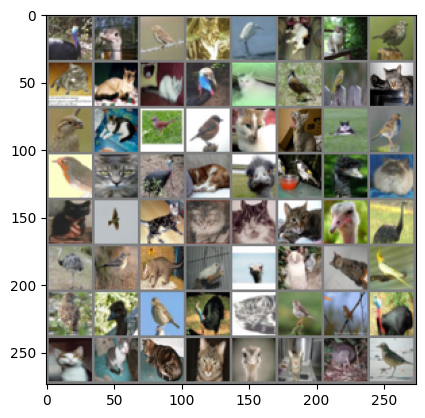

bird  bird  bird  cat   bird  cat   cat   bird  cat   cat   cat   bird  cat   bird  bird  cat   bird  cat   bird  bird  cat   cat   cat   bird  bird  cat   bird  cat   bird  bird  bird  cat   cat   bird  cat   cat   cat   cat   bird  bird  bird  bird  cat   bird  bird  cat   cat   bird  bird  bird  bird  bird  cat   bird  bird  bird  cat   cat   cat   cat   bird  cat   bird  bird 


In [ ]:
# function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize to see the images as they are
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

#Watch out with this, the model needs classes 0 and 1 (not 2 and 3)
unique_labels = torch.unique(labels)
print(unique_labels)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## 2. Define a Convolutional Neural Network

#### Now we are going to create the structure of the neural network. It has to be a Lenet5, so we will concatenate some 2Dconvolutional layers with maximum pooling layers and at the end three normal dense layers.

In [ ]:
#Defining the convolutional neural network
class LeNet5(nn.Module):
    def __init__(self, num_classes):
        super(LeNet5, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(6), #we add batch normalization
            nn.Sigmoid(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Linear(400, 120)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(120, 84)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(84, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)

        #reshape reshapes the out tensor such that the first dimension remains the same (i.e., the batch size)
        # and the second dimension is adjusted to make the tensor a 2-dimensional tensor.
        # This is necessary because fully connected layers require input data to be in the form of a one-dimensional tensor.

        out = out.reshape(out.size(0), -1)

        out = self.fc(out)
        out = self.relu(out)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

#### Train the model

In [ ]:
# Instantiate the model
model = LeNet5(num_classes).to(device)

#Setting the loss function
cost = nn.CrossEntropyLoss()

#Setting the optimizer with the model parameters and learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
import time
start_lenet5=time.time()

In [ ]:
#Training loop

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(trainloader):
        images = images.to(device)

        #Since we are working with a binary classification problem (birds vs cats), the target labels should be either 0 or 1.
        labels_mapped = (labels == 3).long()  # Map label 3 to 1 (cat), all other labels remain 0 (bird)
        labels_mapped=labels_mapped.to(device)

        #Forward pass
        outputs = model(images)
        loss = cost(outputs, labels_mapped)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

#### For testing the model, we are going to create a function that allows adding or not a calibration method.

In [ ]:
# Create a function to test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
def test(model, calibration_method=None, **kwargs):

    y_true = []
    y_pred_probs = []
    labels_oneh = []

    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in testloader:
            images = images.to(device)

            labels_mapped = (labels == 3).long()  # Map label 3 to 1 (cat), all other labels remain 0 (bird)
            labels_mapped=labels_mapped.to(device)

            outputs = model(images)

            #In case there is a calibration function, we pass the outputs of the model before applying the softmax function (logits)
            if calibration_method:
                outputs = calibration_method(outputs, kwargs)

            # Get softmax values for net input and resulting class predictions
            sm = nn.Softmax(dim=1)
            outputs = sm(outputs)

            _, predicted = torch.max(outputs.data, 1)
            outputs = outputs.cpu().detach().numpy()

            # Convert labels to one hot encoding
            # one hot encoding of the labels that we will use to compute the accuracies of each one of the bins of the reliability diagram
            label_oneh = torch.nn.functional.one_hot(labels_mapped, num_classes=num_classes)
            label_oneh = label_oneh.cpu().detach().numpy()
            labels_oneh.extend(label_oneh)


            total += labels_mapped.size(0)
            correct += (predicted == labels_mapped).sum().item()

            y_true.extend(labels_mapped.numpy())
            y_pred_probs.extend(outputs)

        accuracy=correct / total
        print('Accuracy of the network on the 10000 test images: {: .2f} %'.format(100 * accuracy))
        labels_oneh = np.array(labels_oneh).flatten()
        y_true = np.array(y_true)
        return (y_true, y_pred_probs, labels_oneh,accuracy)

y_true, y_pred_probs, labels_oneh, accuracy = test(model)

Accuracy of the network on the 10000 test images:  80.90 %


In [ ]:
time_traintest_lenet5=time.time()-start_lenet5
time_traintest_lenet5

82.75465679168701

## Expected Calibration Error and Reliability Diagram

#### First we are going to create a function to compute the optimum composition of the bins, its sizes, confidences and accuracies measures.


In [ ]:
def bins_composition(y_pred_probs):
  # Assign each prediction to a bin
  num_bins = 10
  bins = np.linspace(0.1, 1, num_bins)
  agrouped = np.digitize(y_pred_probs, bins)

  # Save the accuracy, confidence and size of each bin
  bin_acuracy = np.zeros(num_bins)
  bin_confidence = np.zeros(num_bins)
  bin_sizes = np.zeros(num_bins)

  for bin in range(num_bins):
    bin_sizes[bin] = len(y_pred_probs[agrouped == bin])
    if bin_sizes[bin] > 0:
      bin_acuracy[bin] = (labels_oneh[agrouped==bin]).sum() / bin_sizes[bin]
      bin_confidence[bin] = (y_pred_probs[agrouped==bin]).sum() / bin_sizes[bin]

  return bins, bin_acuracy, bin_confidence, bin_sizes

#### Now we create a function for the ECE computation. For the same price, we have also immlemented the computation of the Maximum Calibration Error (MCE) as an aditional indicator.

In [ ]:
def get_ECE_and_MCE(y_pred_probs):
  ECE = 0
  MCE = 0
  #We use the cal_bins functions to compute the bins sizes, number of bins and accuracy
  bins, bin_acuracy, bin_confidence, bin_sizes = bins_composition(y_pred_probs)

  for i in range(len(bins)):
    difference = abs(bin_acuracy[i] - bin_confidence[i])
    ECE += (bin_sizes[i] / sum(bin_sizes)) * difference
    MCE = max(MCE, difference)

  return ECE, MCE

#### First realiability diagram implementation with sklearn

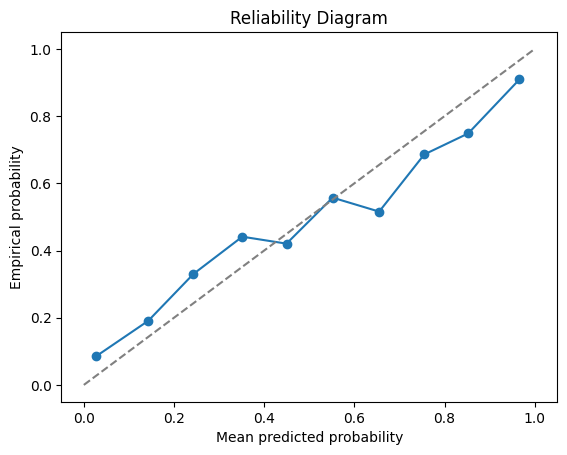

In [ ]:
# Compute the reliability diagram and ECE
y_pred_probs_curve = np.array(y_pred_probs)[:, 1]  # Predicted probability for class 'cat' that is the "positive" class as it was mapped to 1


prob_true, prob_pred = calibration_curve(y_true, y_pred_probs_curve, n_bins=10, strategy='uniform') #uniform strategy as we want all bins to have same length


# Plot the reliability diagram
plt.plot(prob_pred, prob_true, marker='o', linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Mean predicted probability')
plt.ylabel('Empirical probability')
plt.title('Reliability Diagram')
plt.show()


It is quite informative, but we think that we could do better

#### R2 as aditional measure

As an aditional measure of the correctness of the mean predicted probability we have thought in using an easy mechanism, that we leant from predictive models:
- The perfect (but unrealistic) situation would be that our mean predicted probability points linned up over the straigt line of the empirical probability. As the hope is for the plotted points to follow the line y=x, we can use as indirect measure the **R square** from linear models. It measures how close is our blue line of mean predicted probabilities from the one of the empirical ones. It is in the intercal [0,1], the closser we are to 1 the better (being 1 the perfect model but imposible in practice).

In [ ]:
from sklearn.metrics import r2_score

# Calculate R^2
r2 = r2_score(prob_true, prob_pred)

r2

0.8945718210819308

### Expected Calibration Error

In [ ]:
y_pred_probs= np.array(y_pred_probs).flatten()
ece, mce=get_ECE_and_MCE(y_pred_probs)
print('Expected Calibration Error (ECE):', ece)
print('Maximum Calibration Error (MCE):', mce)

Expected Calibration Error (ECE): 0.06518603897094727
Maximum Calibration Error (MCE): 0.1185703862664158


Which is a 6.51% abd 11.85% respectively, it is not very bad but gives space for a huge improvement on the calibration. For that purpose, we are going to try Temperature scaling.

# Temerature scaling

We want to do **Temperature Scaling** to improve the calibration and reliability of neural network predictions. This adjustment helps to bring the output probabilities of the network closer to their true probabilities.

#### As it is usual in our procedure, we will start creating some plotting function that will help us visualice our implementations.

In [ ]:
import matplotlib.patches as mpatches

def reliability_histogram(y_pred_probs):
  ECE, MCE = get_ECE_and_MCE(y_pred_probs)
  bins, bin_accs, _, _ = bins_composition(y_pred_probs)

  fig = plt.figure(figsize=(8, 8))
  ax = fig.gca()

  ax.set_xlim(0, 1.05)
  ax.set_ylim(0, 1.05)

  plt.xlabel('Confidence')
  plt.ylabel('Accuracy')

  #grid
  ax.set_axisbelow(True)
  ax.grid(color='gray', linestyle='dashed')

  # This are the error bars
  plt.bar(bins, bins,  width=0.1, alpha=0.3, edgecolor='black', color='r', hatch='\\')
  plt.bar(bins, bin_accs, width=0.1, alpha=1, edgecolor='black', color='y')

  # Identity line data should fit to
  plt.plot([0,1],[0,1], '--', color='gray', linewidth=2)

  # Equally spaced axes
  plt.gca().set_aspect('equal', adjustable='box')

  # Legend
  unir_ECE = mpatches.Patch(color='green', label='ECE = {:.2f}%'.format(ECE*100))
  unir_MCE = mpatches.Patch(color='red', label='MCE = {:.2f}%'.format(MCE*100))
  plt.legend(handles=[unir_ECE, unir_MCE])



#### Now we create the proper function to T scale the logits. T scaling is quite easy, the difficult part is finding the proper T value

In [ ]:
def T_calibrating(logits, args):
  if type(args)!= int:
    temperature = args.get('temperature', None)
  else:
    temperature=args
  return torch.div(logits, temperature)

## Temperature factor optimization
### Now we need to find a way to optimice the parameter T, this is done by an special training of the model, using a linear seach and passing a parameter (temperature) to optimice

Optimized T_calibrating constant: 1.598


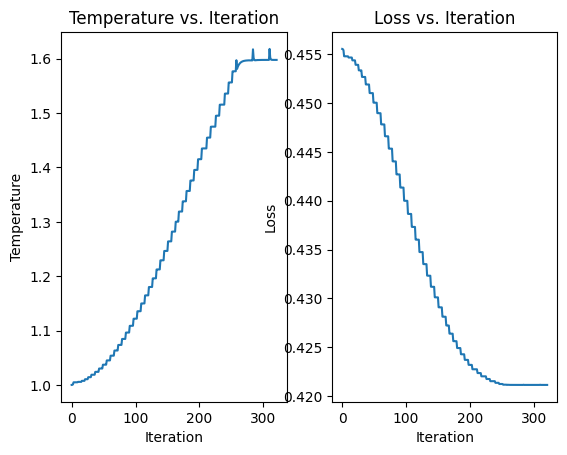

In [ ]:
temperature = nn.Parameter(torch.ones(1))
args = {'temperature': temperature}
criterion = nn.CrossEntropyLoss()

optimizer = optim.LBFGS([temperature], lr=0.001, max_iter=10000, line_search_fn='strong_wolfe')

logits_list = []
labels_list = []
temps = []
losses = []

#Evaluation loop
for i, data in enumerate(testloader, 0):
    images, labels = data[0].to(device), data[1].to(device)

    labels_mapped = (labels == 3).long()  # Map label 3 to 1 (cat), all other labels remain 0 (bird)
    labels_mapped=labels_mapped.to(device)

    model.eval()
    with torch.no_grad():
      logits_list.append(model(images))
      labels_list.append(labels_mapped)

# Create tensors
logits_list = torch.cat(logits_list).to(device)
labels_list = torch.cat(labels_list).to(device)


#FUnction to compute the loss of T_calibrating and optimize its parameter
def _eval():
  loss = criterion(T_calibrating(logits_list, args), labels_list)
  loss.backward()
  temps.append(temperature.item())
  losses.append(loss.cpu().detach().numpy())
  return loss


optimizer.step(_eval)

print('Optimized T_calibrating constant: {:.3f}'.format(temperature.item()))

plt.subplot(121)
plt.plot(list(range(len(temps))), temps)
plt.xlabel('Iteration')
plt.ylabel('Temperature')
plt.title('Temperature vs. Iteration')

plt.subplot(122)
plt.plot(list(range(len(losses))), losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss vs. Iteration')
plt.show()



## Finally we plot the improved reliability diagrams to commpare the effect of T scaling
#### On the first one of them we plot the reliability diagram of the test phase with out T scaling
#### On the second one of them we plot the reliability diagram of the test phase with T scaling

Accuracy of the network on the 10000 test images:  80.95 %
Accuracy of the network on the 10000 test images:  80.95 %


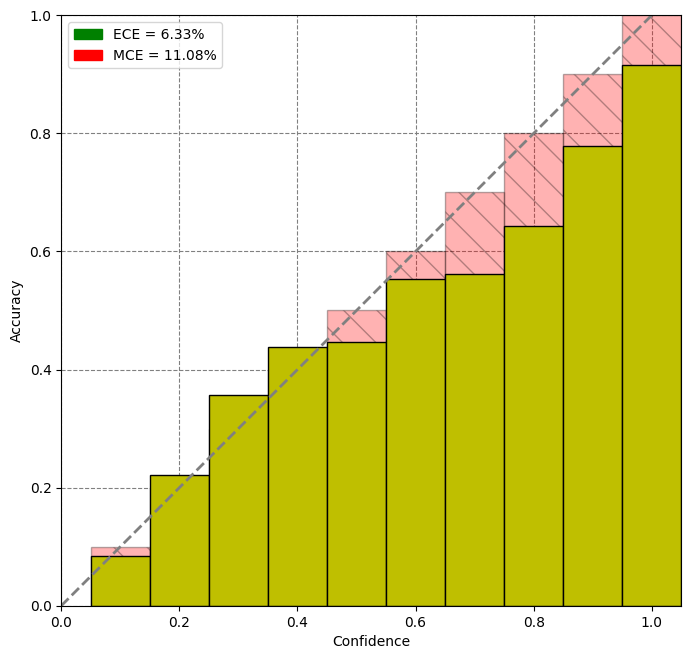

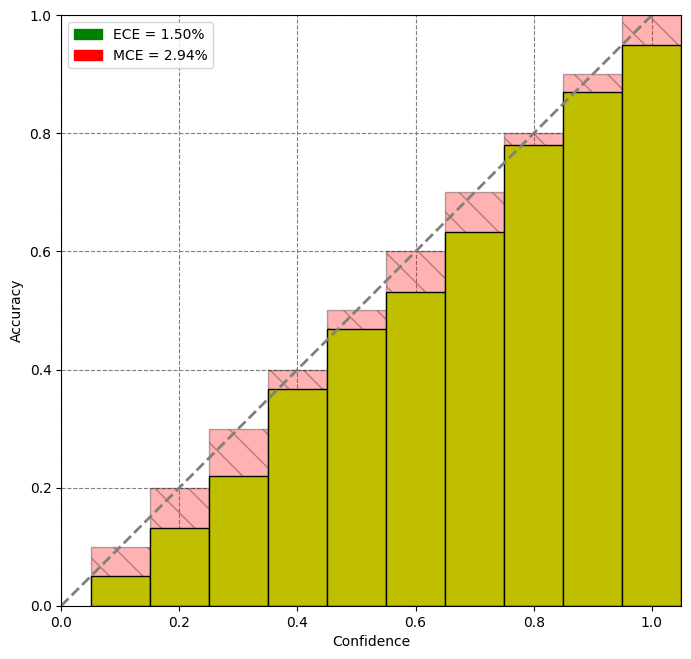

In [ ]:
_,original_preds, _,_ = test(model)
y_true_calibrated, calibrated_preds, _,_ = test(model,T_calibrating, temperature=temperature)

original_preds_fattened= np.array(original_preds).flatten()
calibrated_preds_flattened= np.array(calibrated_preds).flatten()

reliability_histogram(original_preds_fattened)
reliability_histogram(calibrated_preds_flattened)

By plotting the statistical accuracy as a function of confidence(estimated accuracy), we can visualize how well the confidence reflects the true accuracy. We see that in the lower plot (calibrated model), the bins adjust better to the middle line in relation to the uncalibrated model, that has more deviations from the line y=x and is more arbitrary. In this way we can see how well the predicted confidence scores hold up against their actual accuracy.

#### The metrics of the calibrated model are:

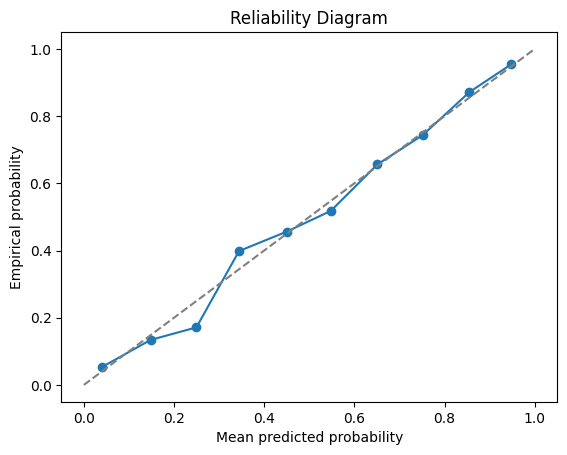

calibrated ECE and MCE:  0.015017102241516095 0.029402464009180257
R2 0.9877693171824528


In [ ]:
# Compute the reliability diagram and ECE
calibrated_preds = np.array(calibrated_preds)[:, 1]  # Predicted probability for class 'cat' that is the "positive" class as it was mapped to 1


prob_true, prob_pred = calibration_curve(y_true_calibrated, calibrated_preds, n_bins=10, strategy='uniform') #uniform strategy as we want all bins to have same length


# Plot the reliability diagram
plt.plot(prob_pred, prob_true, marker='o', linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Mean predicted probability')
plt.ylabel('Empirical probability')
plt.title('Reliability Diagram')
plt.show()
ece, mce= get_ECE_and_MCE(calibrated_preds_flattened)
print('calibrated ECE and MCE: ', ece, mce)

# Calculate R^2
r2 = r2_score(prob_true, prob_pred)

print("R2", r2)

We see that all the indicators have gotten better, the ECE and MCE are lower and the r2 bigger than the ones from the model with out calibration. This is reflected in the plot by the fact that the blue line (from our predictions) fits better the identity line (x=y).

### Lets see how the Temperature factor affects the model

Accuracy of the network on the 10000 test images:  80.95 %
Accuracy of the network on the 10000 test images:  80.95 %
Accuracy of the network on the 10000 test images:  80.95 %
Accuracy of the network on the 10000 test images:  80.95 %
Accuracy of the network on the 10000 test images:  80.95 %
Accuracy of the network on the 10000 test images:  80.95 %


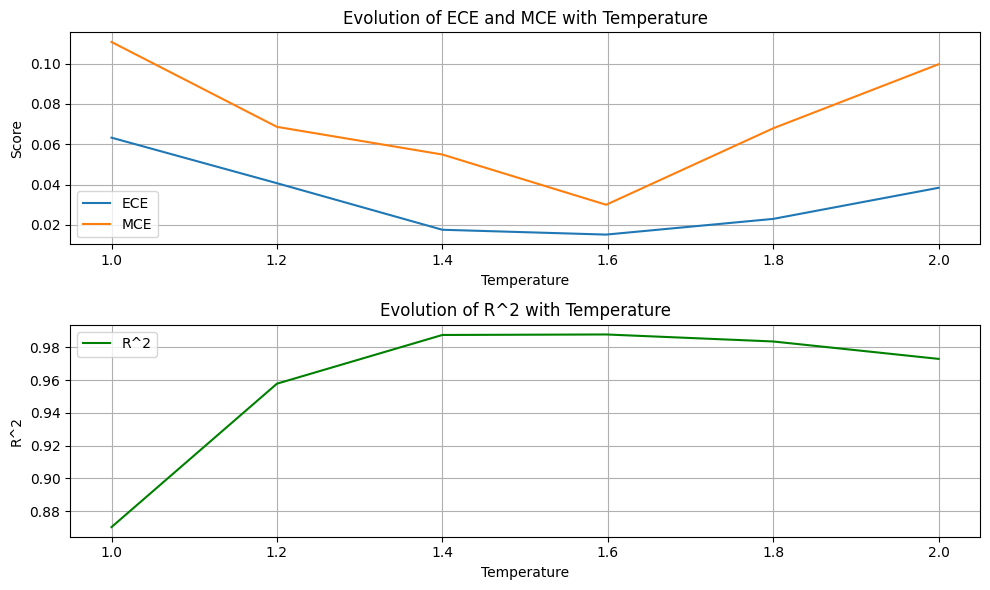

In [ ]:
t_list=[1,1.2, 1.4, 1.598,1.8,2]
ece_list=[]
mce_list=[]
r2_list=[]

for temperature in t_list:

  y_true_calibrated, calibrated_preds, _,_ = test(model,T_calibrating, temperature=temperature)

  calibrated_preds_flattened= np.array(calibrated_preds).flatten()

  calibrated_preds = np.array(calibrated_preds)[:, 1]  # Predicted probability for class 'cat' that is the "positive" class as it was mapped to 1
  prob_true, prob_pred = calibration_curve(y_true_calibrated, calibrated_preds, n_bins=10, strategy='uniform') #uniform strategy as we want all bins to have same length
  ece, mce= get_ECE_and_MCE(calibrated_preds_flattened)
  r2 = r2_score(prob_true, prob_pred)

  ece_list.append(ece)
  mce_list.append(mce)
  r2_list.append(r2)

# Plotting ECE and MCE
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(t_list, ece_list, label='ECE')
plt.plot(t_list, mce_list, label='MCE')
plt.xlabel('Temperature')
plt.ylabel('Score')
plt.title('Evolution of ECE and MCE with Temperature')
plt.legend()
plt.grid(True)

# Plotting R^2
plt.subplot(2, 1, 2)
plt.plot(t_list, r2_list, label='R^2', color='green')
plt.xlabel('Temperature')
plt.ylabel('R^2')
plt.title('Evolution of R^2 with Temperature')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

As expected, the accuracy of the model does not change (as we are not changing the predictions, only the confidence of them). But the ECE, MCE and R2 depends heavily on these factor.
 In addition, we can see that the temperature factore obtained from the previous part (1.598) is the one that minimizes the ECE and MCE, and also maximizes the R2 (the R2 is similar in some other places but this is due to the fact that R2 is an indirect measure, so we are not maximizing it explicitly).

## Lets see how well does it predict some pictures

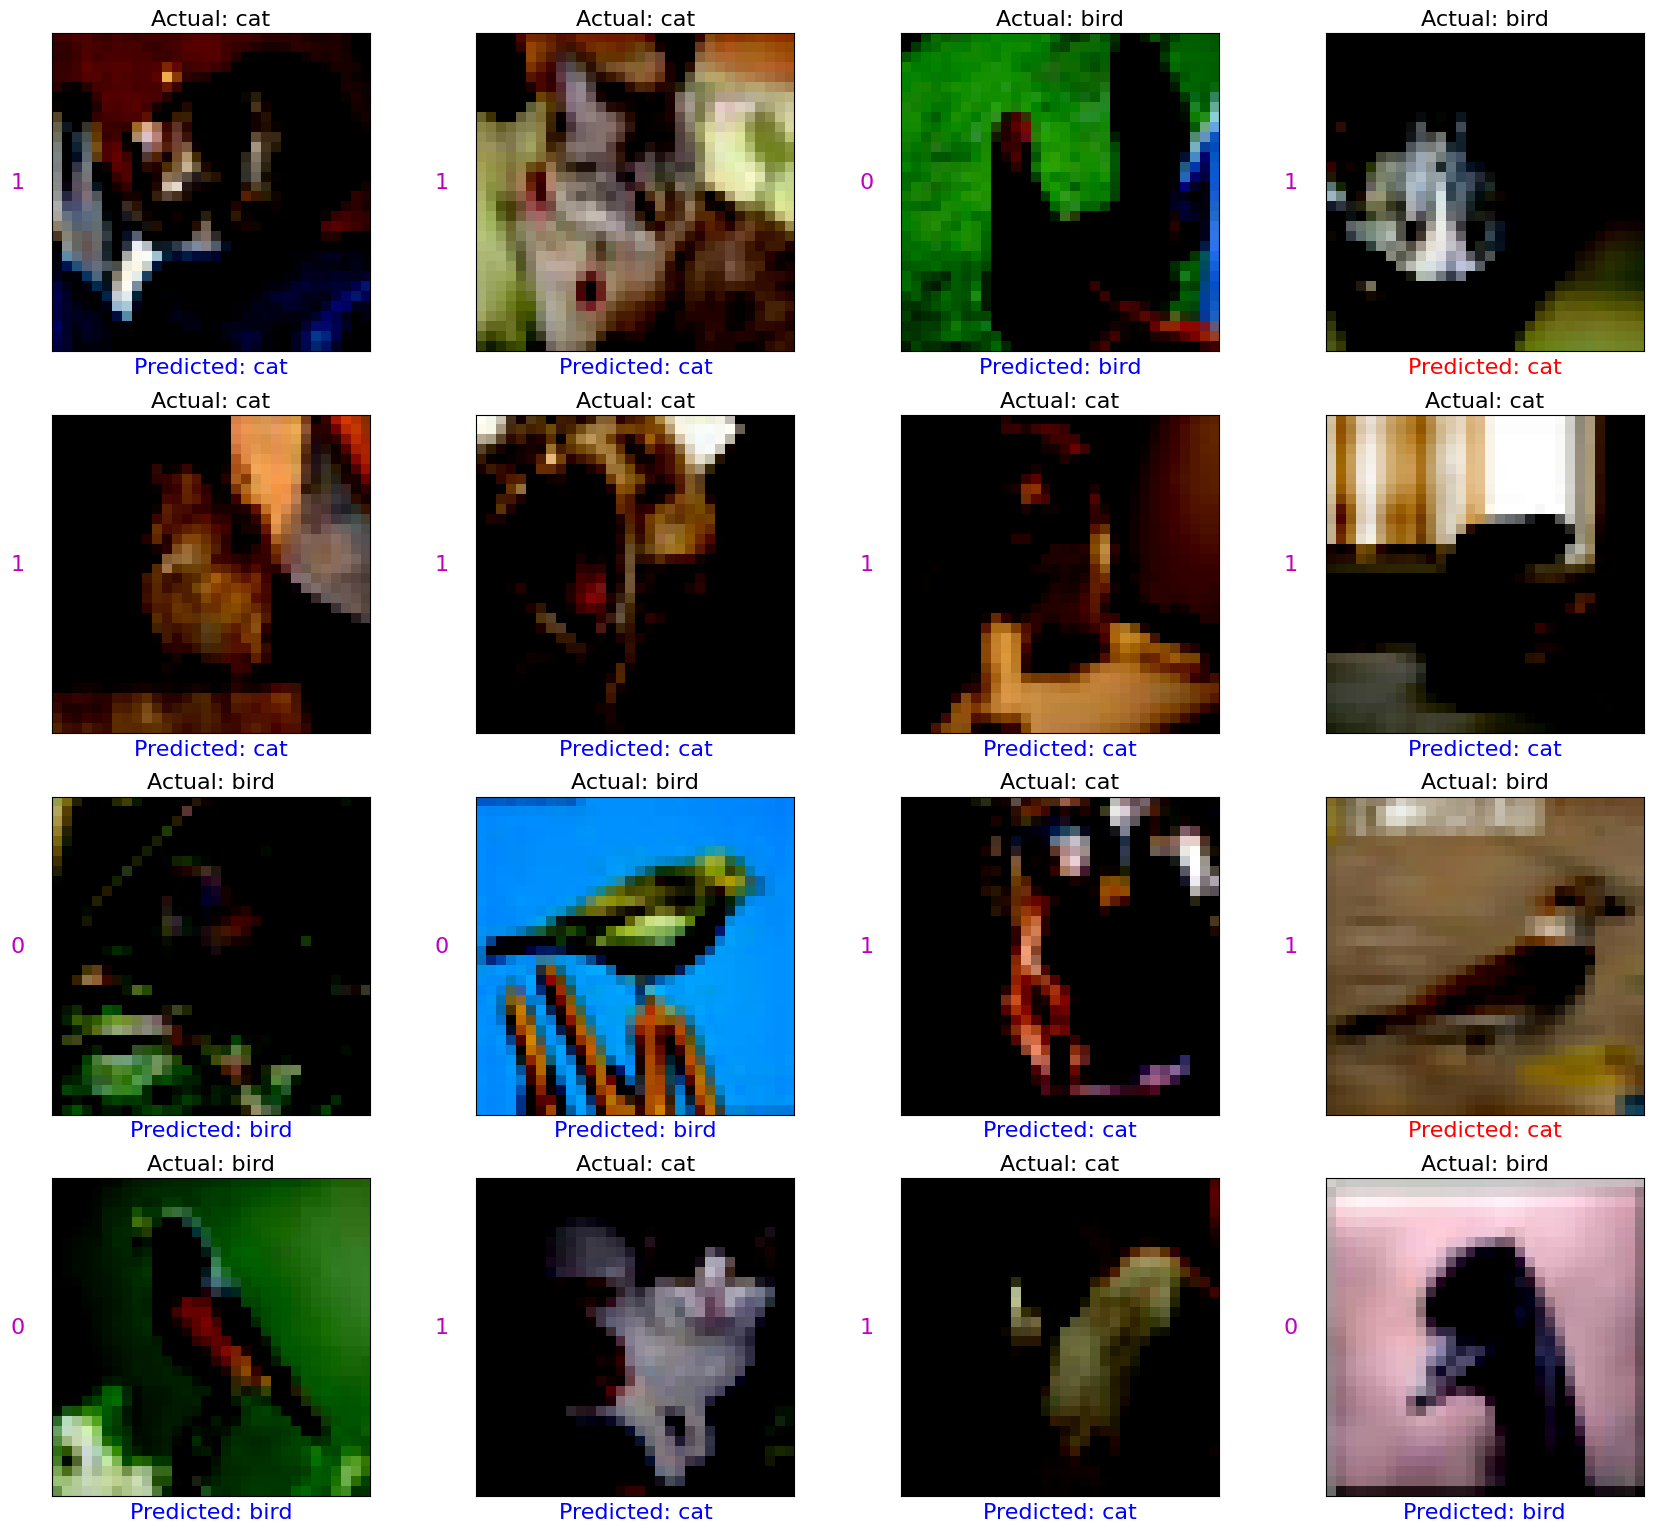

In [ ]:
import torch.nn.functional as F

SAMPLES, PREDS, LABELS = [], [], []


for i in range(16):

    indices = np.random.randint(len(testset))

    SAMPLES.append(testset[i])
    outputs= model.cpu()(testset[i][0].unsqueeze(0))

    labels_mapped = (testset[i][1] == 3)  # Map label 3 to 1 (cat), all other labels remain 0 (bird)
    labels_mapped=labels_mapped

    outputs = T_calibrating(outputs, temperature)
    sm = nn.Softmax(dim=1)
    outputs = sm(outputs)

    pred_values, pred_labels = torch.max(outputs.data, 1)

    #We mapped our classes to be 0 and 1 so the model could handle them, but we need to reconvert them to the original class numbers,
    # if not the names of the labels are the ones of the original classes 0 and 1 (car and plane from the original classes list)
    if pred_labels==1:
      labels_mapped=3
    elif pred_labels==0:
      labels_mapped=2

    PREDS.append(int(pred_labels))
    LABELS.append(labels_mapped)

fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(21, 19))
i = 0
for R in range(4):
    for C in range(4):
        ax[R, C].imshow(torch.clamp(SAMPLES[i][0], min=0, max=1).permute(1, 2, 0))
        ax[R, C].set_title('Actual: ' + classes[SAMPLES[i][1]], fontsize=16).set_color('k') # actual labels
        if SAMPLES[i][1] == LABELS[i]:
            ax[R, C].set_xlabel('Predicted: ' + classes[LABELS[i]], fontsize=16).set_color('b') # correctly predicted labels
        else:
            ax[R, C].set_xlabel('Predicted: ' + classes[LABELS[i]], fontsize=16).set_color('r') # wrongly predicted labels
        ax[R, C].set_ylabel(PREDS[i], fontsize=16, rotation=0, labelpad=25).set_color('m') # probability of predicted class
        ax[R, C].set_xticks([])
        ax[R, C].set_yticks([])
        i += 1

## Conclusions

We see that aplying T scaling is quite usefull for reducing both the Expected calibrating error and the Maximum calibrating error, but with out reducing the accuracy of our model. This leads to a better model, obtaining well-calibrated confidence estimates that leads to better interpretability and decision making, as the calibration error is reduced.

# Using EfficientNet as pretrained model

The idea now is to use a previously-trained model to do the clasiffication task we have. For that, we have decided to use AlexNet, that with a small train on our data we think it can make better predictions

In [ ]:
from torchvision import models

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Redimensionar las imágenes a 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalizar los datos
])

#apply de transformation to the previously created dataloaders and datasets
trainloader.dataset.transform=transform
testloader.dataset.transform=transform
trainset.transform = transform
testset.transform = transform

weights=models.AlexNet_Weights.DEFAULT
get_=weights.transforms()
get_

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [ ]:
alexnet = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 115MB/s]


### We must modify the model architecture to adapt it to CIFAR10 and our goal

In [ ]:
modified_alexnet = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)
#This loop is to froze the layers from the trained models and avoid that they change too much during training
for param in modified_alexnet.parameters():
    param.requires_grad = False

#We add some layers to adapt the model to our data
modified_alexnet.avgpool = nn.AdaptiveAvgPool2d(output_size=(2, 2))

modified_alexnet.classifier = nn.Sequential()
modified_alexnet.classifier.add_module('dropout1', nn.Dropout(p=0.5))
modified_alexnet.classifier.add_module('linear1', nn.Linear(in_features=1024, out_features=512))
modified_alexnet.classifier.add_module('relu1', nn.ReLU(inplace=True))
modified_alexnet.classifier.add_module('dropout2', nn.Dropout(p=0.5))
modified_alexnet.classifier.add_module('linear2', nn.Linear(in_features=512, out_features=512))
modified_alexnet.classifier.add_module('relu2', nn.ReLU(inplace=True))
modified_alexnet.classifier.add_module('dropout3', nn.Dropout(p=0.5))
modified_alexnet.classifier.add_module('linear3', nn.Linear(in_features=512, out_features=num_classes))

In [ ]:
model_to_train = modified_alexnet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_to_train.parameters(), lr=0.001)

### Lets define some functions for training and testing

In [ ]:
def train_batch(data,labels,model,criterion,optimizer):
  model.train()
  data=data.to(device)
  labels_mapped = (labels == 3).long()  # Map label 3 to 1 (cat), all other labels remain 0 (bird)
  labels_mapped=labels_mapped.to(device)
  output=model(data)
  loss=criterion(output,labels_mapped)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  return loss

In [ ]:
with torch.inference_mode():
  def test_batch(data, labels, model, criterion):
    model.eval()
    data=data.to(device)
    labels_mapped = (labels == 3).long()  # Map label 3 to 1 (cat), all other labels remain 0 (bird)
    labels_mapped=labels_mapped.to(device)
    output=model(data)
    loss=criterion(output,labels_mapped)
    return loss

In [ ]:
#Define the accuracy

with torch.inference_mode():
  def accuracy(data, labels, model):
    model.eval()
    data=data.to(device)
    labels_mapped = (labels == 3).long()  # Map label 3 to 1 (cat), all other labels remain 0 (bird)
    labels_mapped=labels_mapped.to(device)
    output=model(data)
    _,pred_labels=output.max(-1)
    correct=(pred_labels==labels_mapped)
    return correct.cpu().detach().numpy().tolist()

Start the training and testing

In [ ]:
model_to_train=modified_alexnet.to(device)
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model_to_train.parameters(),lr=0.001)

In [ ]:
start_alex=time.time()

In [ ]:
n_epochs = 5

training_loss, test_loss = [], []
training_accuracy, test_accuracy = [], []

for epoch in range(n_epochs):
    training_losses, test_losses = [], []
    training_accuracies, test_accuracies = [], []

    for data, labels in trainloader:
        trng_batch_loss = train_batch(data, labels, model_to_train, criterion, optimizer)
        training_losses.append(trng_batch_loss.item())
        trng_batch_correct = accuracy(data, labels, model_to_train)
        training_accuracies.extend(trng_batch_correct)
    training_per_epoch_loss = np.array(training_losses).mean()
    training_per_epoch_accuracy = np.mean(training_accuracies)

    for data, labels in testloader:
        tst_batch_loss = test_batch(data, labels, model_to_train, criterion)
        test_losses.append(tst_batch_loss.item())
        tst_batch_correct = accuracy(data, labels, model_to_train)
        test_accuracies.extend(tst_batch_correct)
    test_per_epoch_loss = np.array(test_losses).mean()
    test_per_epoch_accuracy = np.mean(test_accuracies)

    training_loss.append(training_per_epoch_loss)
    training_accuracy.append(training_per_epoch_accuracy)
    test_loss.append(test_per_epoch_loss)
    test_accuracy.append(test_per_epoch_accuracy)

    print(f'Epoch: {epoch+1}/{n_epochs} | Training loss: {training_per_epoch_loss:.4f} | ', end='')
    print(f'Training accuracy: {training_per_epoch_accuracy:.4f} | Test loss: {test_per_epoch_loss:.4f} | ', end='')
    print(f'Test accuracy: {test_per_epoch_accuracy:.4f}')

Epoch: 1/5 | Training loss: 0.2695 | Training accuracy: 0.9283 | Test loss: 0.2408 | Test accuracy: 0.9035
Epoch: 2/5 | Training loss: 0.2574 | Training accuracy: 0.9319 | Test loss: 0.2258 | Test accuracy: 0.9050
Epoch: 3/5 | Training loss: 0.2532 | Training accuracy: 0.9367 | Test loss: 0.2084 | Test accuracy: 0.9190
Epoch: 4/5 | Training loss: 0.2434 | Training accuracy: 0.9400 | Test loss: 0.2108 | Test accuracy: 0.9170
Epoch: 5/5 | Training loss: 0.2414 | Training accuracy: 0.9422 | Test loss: 0.2087 | Test accuracy: 0.9250


In [ ]:
time_traintest_alex=time.time()-start_alex
time_traintest_alex

3977.1861383914948

## Model loss and accuracy

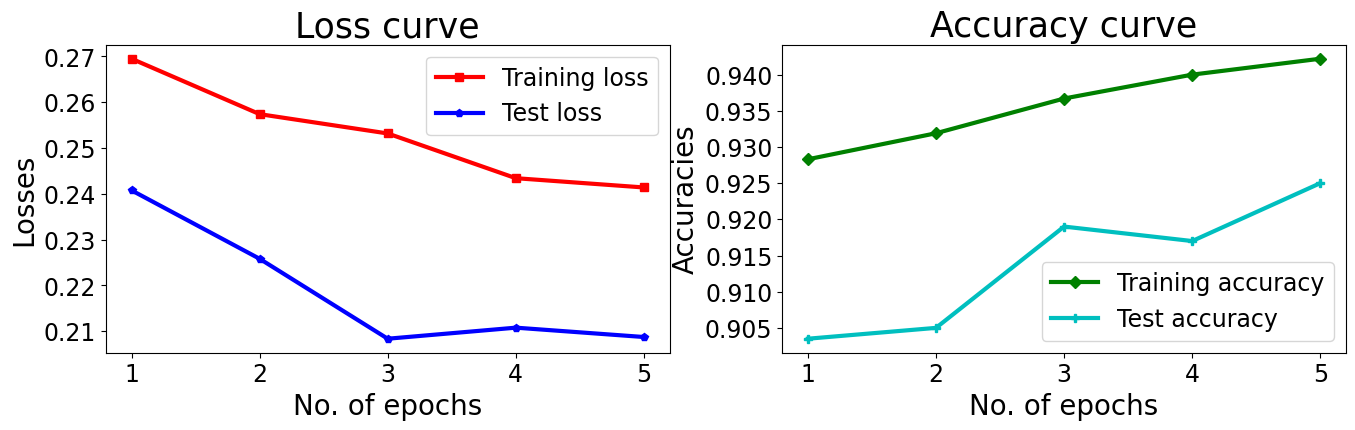

In [ ]:
N = np.arange(n_epochs) + 1

fig = plt.figure(figsize=(16, 4))

fig.add_subplot(1, 2, 1)
plt.plot(N, training_loss, 'r-s', linewidth=3, label='Training loss')
plt.plot(N, test_loss, 'b-p', linewidth=3, label='Test loss')
plt.title('Loss curve', fontsize=25)
plt.xlabel('No. of epochs', fontsize=20)
plt.ylabel('Losses', fontsize=20)
plt.xticks([1, 2, 3, 4, 5], fontsize=17)
plt.yticks(fontsize=17)
plt.legend(fontsize=17)

fig.add_subplot(1, 2, 2)
plt.plot(N, training_accuracy, 'g-D', linewidth=3, label='Training accuracy')
plt.plot(N, test_accuracy, 'c-P', linewidth=3, label='Test accuracy')
plt.title('Accuracy curve', fontsize=25)
plt.xlabel('No. of epochs', fontsize=20)
plt.ylabel('Accuracies', fontsize=20)
plt.xticks([1, 2, 3, 4, 5], fontsize=17)
plt.yticks(fontsize=17)
plt.legend(fontsize=17);

## Model ECE and MCE

In [ ]:
_,original_preds, _,_ = test(model_to_train)

original_preds_fattened= np.array(original_preds).flatten()
ece, mce=get_ECE_and_MCE(original_preds_fattened)
print('Expected Calibration Error (ECE):', ece)
print('Maximum Calibration Error (MCE):', mce)

Accuracy of the network on the 10000 test images:  92.50 %
Expected Calibration Error (ECE): 0.032032933695546516
Maximum Calibration Error (MCE): 0.13425133171982662


##### We see that the ECE and MCE is quite high, so we will use the temperature scaling that worked correctly with Lenet5 for this new model, to try to calibrate it

## Model prediction

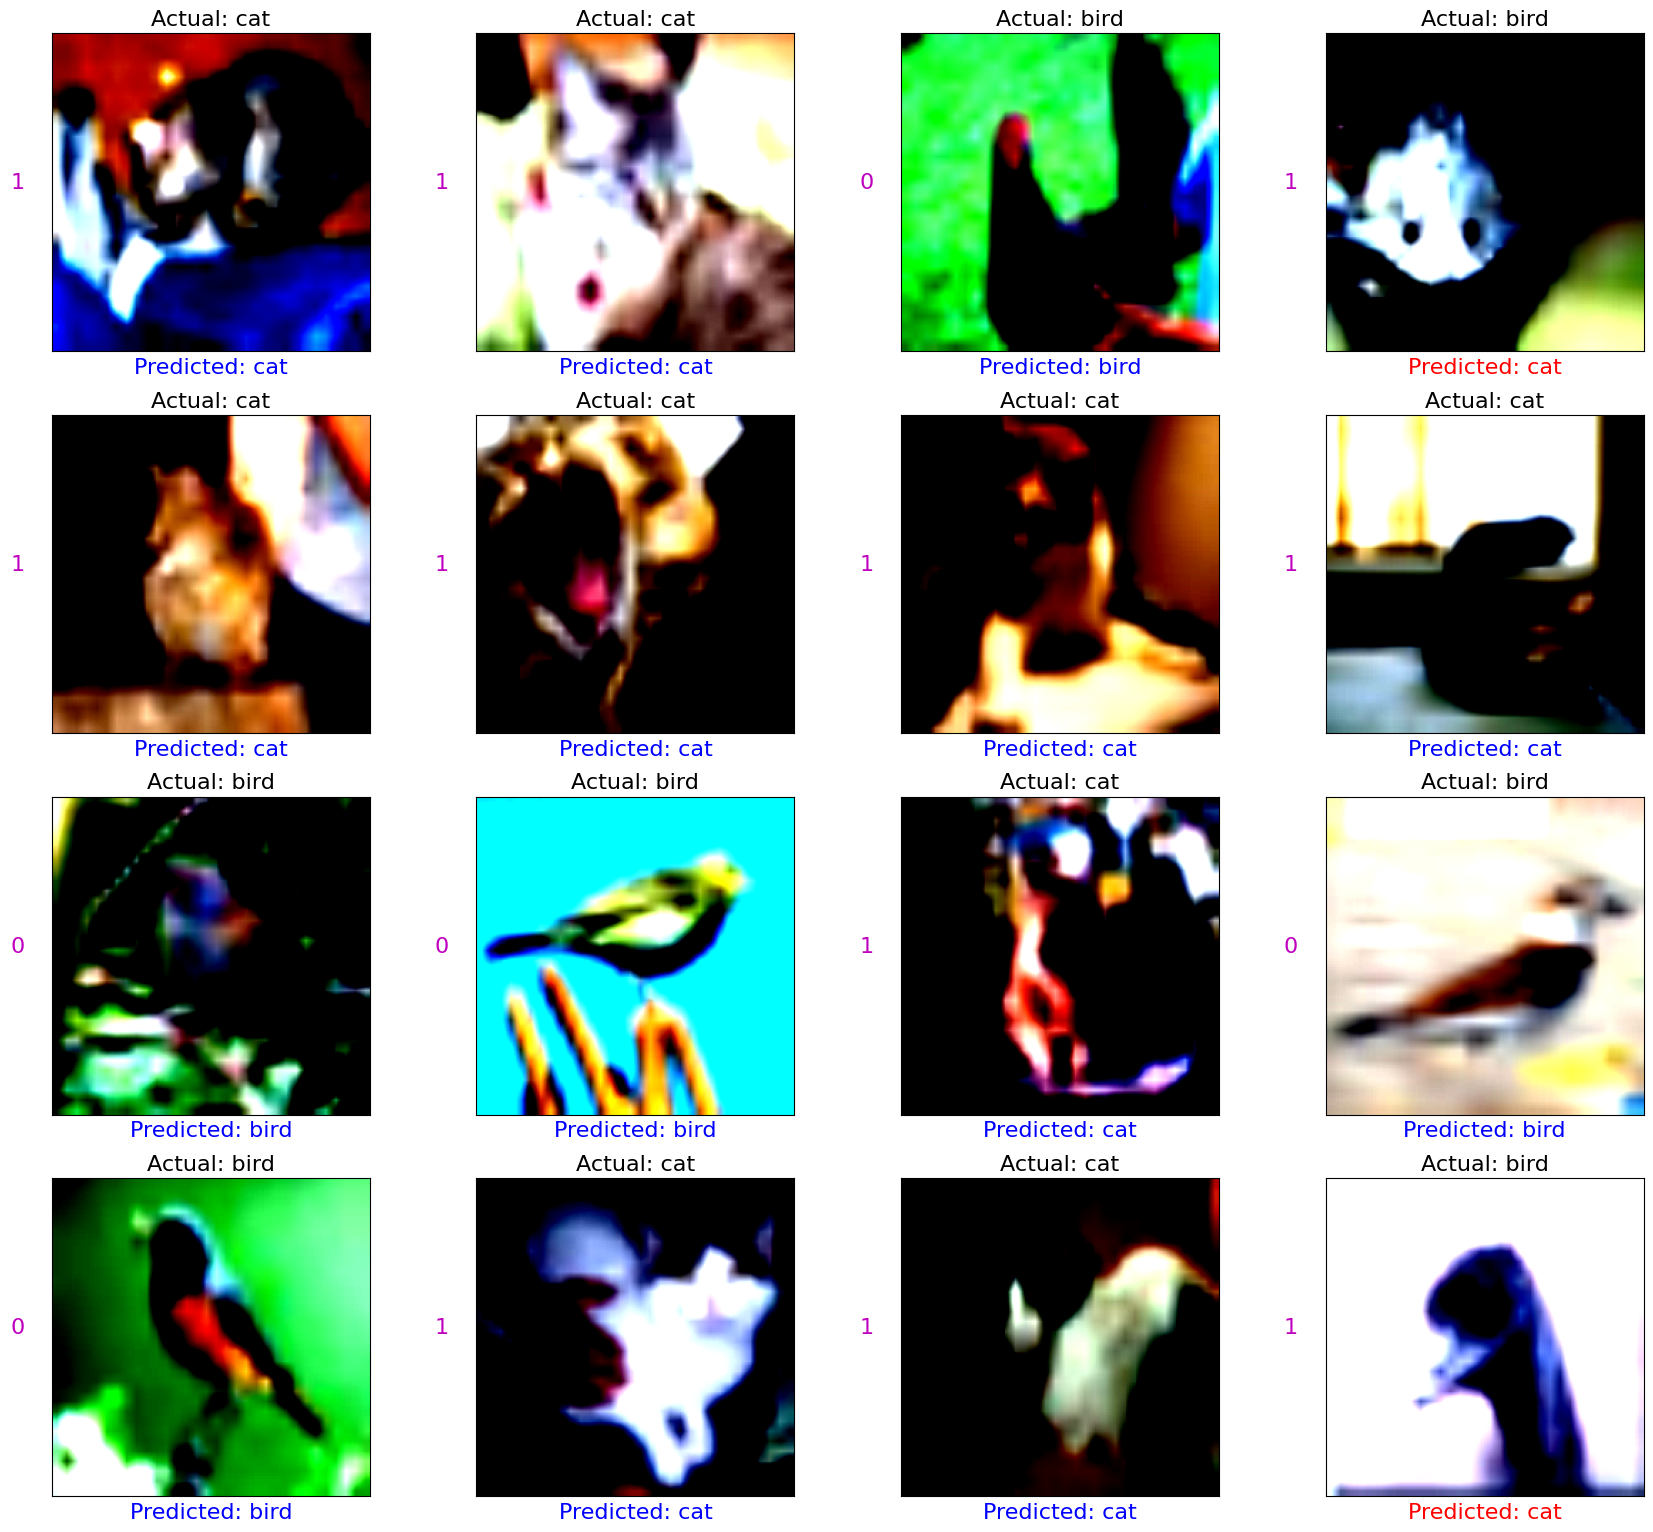

In [ ]:
import torch.nn.functional as F

SAMPLES, PREDS, LABELS = [], [], []


for i in range(16):

    indices = np.random.randint(len(testset))

    SAMPLES.append(testset[i])
    outputs= model_to_train.cpu()(testset[i][0].unsqueeze(0))

    labels_mapped = (testset[i][1] == 3)  # Map label 3 to 1 (cat), all other labels remain 0 (bird)
    labels_mapped=labels_mapped

    outputs = T_calibrating(outputs, temperature)
    sm = nn.Softmax(dim=1)
    outputs = sm(outputs)

    pred_values, pred_labels = torch.max(outputs.data, 1)

    #We mapped our classes to be 0 and 1 so the model could handle them, but we need to reconvert them to the original class numbers,
    # if not the names of the labels are the ones of the original classes 0 and 1 (car and plane from the original classes list)
    if pred_labels==1:
      labels_mapped=3
    elif pred_labels==0:
      labels_mapped=2

    PREDS.append(int(pred_labels))
    LABELS.append(labels_mapped)

fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(21, 19))
i = 0
for R in range(4):
    for C in range(4):
        ax[R, C].imshow(torch.clamp(SAMPLES[i][0], min=0, max=1).permute(1, 2, 0))
        ax[R, C].set_title('Actual: ' + classes[SAMPLES[i][1]], fontsize=16).set_color('k') # actual labels
        if SAMPLES[i][1] == LABELS[i]:
            ax[R, C].set_xlabel('Predicted: ' + classes[LABELS[i]], fontsize=16).set_color('b') # correctly predicted labels
        else:
            ax[R, C].set_xlabel('Predicted: ' + classes[LABELS[i]], fontsize=16).set_color('r') # wrongly predicted labels
        ax[R, C].set_ylabel(PREDS[i], fontsize=16, rotation=0, labelpad=25).set_color('m') # probability of predicted class
        ax[R, C].set_xticks([])
        ax[R, C].set_yticks([])
        i += 1

We can see that the predictions are better: only 1 bad out of 16 while the other had 3

## Temperature Scaling for AlexNet

Optimized T_calibrating constant: 0.794


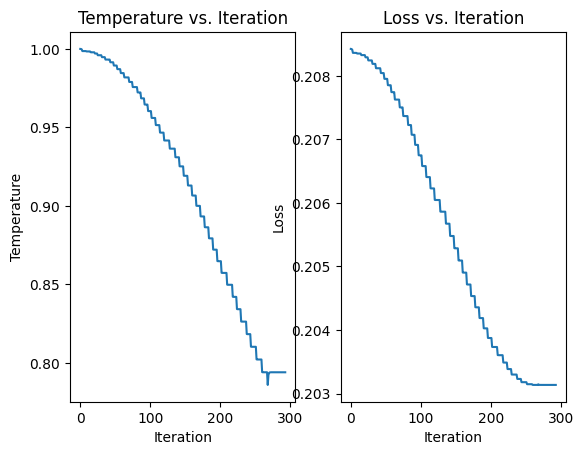

In [ ]:
temperature = nn.Parameter(torch.ones(1))
args = {'temperature': temperature}
criterion = nn.CrossEntropyLoss()

# Removing strong_wolfe line search results in jump after 50 epochs
optimizer = optim.LBFGS([temperature], lr=0.001, max_iter=10000, line_search_fn='strong_wolfe')

logits_list = []
labels_list = []
temps = []
losses = []

#Evaluation loop
for i, data in enumerate(testloader, 0):
    images, labels = data[0].to(device), data[1].to(device)

    labels_mapped = (labels == 3).long()  # Map label 3 to 1 (cat), all other labels remain 0 (bird)
    labels_mapped=labels_mapped.to(device)

    model_to_train.eval()
    with torch.no_grad():
      logits_list.append(model_to_train(images))
      labels_list.append(labels_mapped)

# Create tensors
logits_list = torch.cat(logits_list).to(device)
labels_list = torch.cat(labels_list).to(device)


#FUnction to compute the loss of T_calibrating and optimize its parameter
def _eval():
  loss = criterion(T_calibrating(logits_list, args), labels_list)
  loss.backward()
  temps.append(temperature.item())
  losses.append(loss.cpu().detach().numpy())
  return loss


optimizer.step(_eval)

print('Optimized T_calibrating constant: {:.3f}'.format(temperature.item()))

plt.subplot(121)
plt.plot(list(range(len(temps))), temps)
plt.xlabel('Iteration')
plt.ylabel('Temperature')
plt.title('Temperature vs. Iteration')

plt.subplot(122)
plt.plot(list(range(len(losses))), losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss vs. Iteration')
plt.show()



Accuracy of the network on the 10000 test images:  92.50 %


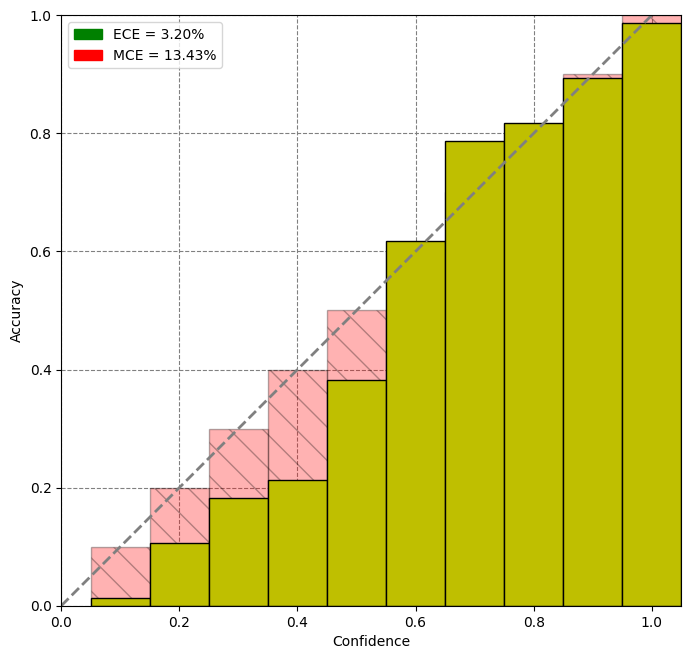

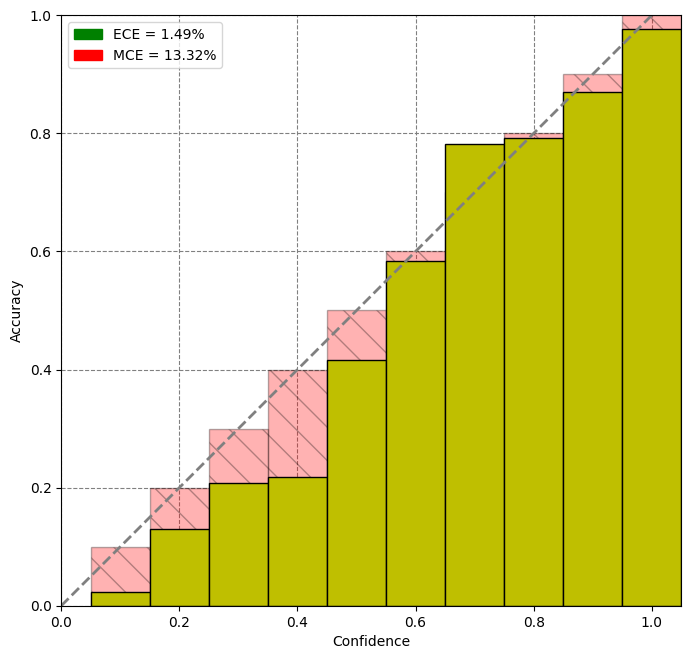

In [ ]:
y_true_calibrated, calibrated_preds, _,_ = test(model_to_train,T_calibrating, temperature=temperature)

calibrated_preds_flattened= np.array(calibrated_preds).flatten()

reliability_histogram(original_preds_fattened)
reliability_histogram(calibrated_preds_flattened)

#### In conclusion, using a pre-trained model is a great option. We take advantage of a much bigger model and its previos training which results in a higher accuracy. However, while the ECE for both models is similar, the MCE for the pre-trained model is significantly large with respect to the simpler one made from scratch. We must also consider the difference in time, since training the hole Lenet5 model took less than 1 minute and a half, but the training necesary for the bigger model took almost 67 minutes. Having said this, we think that the higger amount of time is a price worth to pay for obtaining a 10% more of accuracy on the image classifications. Specially, depending on the task we make, having a little increase in the accuracy of the predictions could be determining.

#### Time difference between the two models

In [ ]:
difference_in_time=time_traintest_alex-time_traintest_lenet5
display(difference_in_time)

difference_in_time_min=difference_in_time/60 #To see it in minutes, which is more informative
difference_in_time_min

3894.4314815998077

64.9071913599968